In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet34, resnet18, vgg11
from sklearn.metrics import confusion_matrix, f1_score
import random
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

import math
from tqdm import tqdm

In [2]:
resnet18 = models.resnet18(pretrained=True)
resnet34 = models.resnet34(pretrained=True)
# Error daram baraye hamin vgg11 ro String dadam felan :) (PytorchStreamReader failed reading zip archive: failed finding central directory)
# vgg11 = models.vgg11(pretrained=True)
vgg11 = "vgg11"
ReLU = nn.ReLU()
Sigmoid = nn.Sigmoid()

In [3]:
FEATURE_EXTRACTOR = [resnet18, resnet34, vgg11]
NUM_HIDDEN_LAYERS = [0, 1, 2]
NUM_NEURONS = [10, 20, 30]
ACTIVATION_FUNC = [ReLU, Sigmoid]

ARCHITECTURE_CONFIG = [FEATURE_EXTRACTOR, NUM_HIDDEN_LAYERS, NUM_NEURONS, ACTIVATION_FUNC]

N_ITER = 10
POPULATION_SIZE = 10
MUT_PROB = 0.1
RECOMB_PROB = 0.9

TRAIN_DATA_BATCH_SIZE = 4
TEST_DATA_BATCH_SIZE = 4
BATCH_SIZE = 4

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

image_datasets = {'train': train_data, 'val': test_data}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# ----------------------------------------------------------------------------------------------------------------------------

# train_dataloader = DataLoader(train_data, batch_size=TRAIN_DATA_BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=TEST_DATA_BATCH_SIZE, shuffle=False)

# train_inputs, train_labels = next(iter(train_dataloader))
# test_inputs, test_labels = next(iter(test_dataloader))

Files already downloaded and verified
Files already downloaded and verified


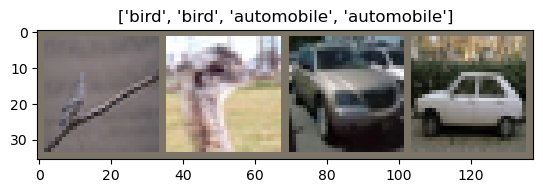

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
# TODO: COMPLETE GENERATE_MODEL FUNCTION
def generate_model(arch):
    pass

In [9]:
def train_network(arch):
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model = generate_model(arch)
    model, accuracy = train_model(model, criterion, optimizer_ft, exp_lr_scheduler)
    
    return model, accuracy   

In [10]:
def calculate_k(population_size, curr_iter):
    return max(2, population_size * curr_iter // N_ITER)

In [11]:
class Chromosome:
    def __init__(self, mut_prob, recomb_prob):
        self.arch = None
        self.mut_prob = mut_prob
        self.recomb_prob = recomb_prob
        self.fitness = 0
        self.model = None
        self.init_chromosome()
        
    def init_chromosome(self):
        feature_extractor = random.choice(FEATURE_EXTRACTOR)
        num_hidden_layers = random.choice(NUM_HIDDEN_LAYERS)
        num_neurons = random.choices(NUM_NEURONS, k = num_hidden_layers)
        activation_func = random.choices(ACTIVATION_FUNC, k = num_hidden_layers)
        self.arch = (feature_extractor, num_hidden_layers, num_neurons, activation_func)
        
    def mutation(self):
        prob = random.uniform(0, 1)
        
        if prob <= self.mut_prob:
            idx = round(random.uniform(0, 3))
            
            if idx == 0:
                while True:
                    feature_extractor = random.choice(FEATURE_EXTRACTOR)
                    if feature_extractor != self.arch[idx]:
                        break
                        
                self.arch = (feature_extractor, self.arch[1], self.arch[2], self.arch[3])
                
            elif idx == 1:
                while True:
                    num_hidden_layers = random.choice(NUM_HIDDEN_LAYERS)
                    num_neurons = random.choices(NUM_NEURONS, k = num_hidden_layers)
                    activation_func = random.choices(ACTIVATION_FUNC, k = num_hidden_layers)
                    if num_hidden_layers != self.arch[idx]:
                        break
                        
                self.arch = (self.arch[0], num_hidden_layers, num_neurons, activation_func)
                
            elif idx == 2:
                while True:
                    num_neurons = random.choices(NUM_NEURONS, k = self.arch[1])
                    if num_neurons != self.arch[idx] or self.arch[1] == 0:
                        break
                        
                self.arch = (self.arch[0], self.arch[1], num_neurons, self.arch[3])
                    
            elif idx == 3:
                while True:
                    activation_func = random.choices(ACTIVATION_FUNC, k = self.arch[1])
                    if activation_func != self.arch[idx] or self.arch[1] == 0:
                        break
                        
                self.arch = (self.arch[0], self.arch[1], self.arch[2], activation_func)
                    
            self.calculate_fitness()

    def calculate_fitness(self):
        self.fitness = round(random.uniform(0, 10))
#         self.model, self.fitness = train_network(self.arch)

In [12]:
class EvolutionaryAlgorithm:
    def __init__(self, n_iter, mut_prob, recomb_prob, population_size):
        self.n_iter = n_iter
        self.mut_prob = mut_prob
        self.recomb_prob = recomb_prob
        self.population = []
        self.population_size = population_size
        self.current_iter = 0
        self.fitness_avg = 0
        self.fitness_history = []

    # Random initialization
    def init_population(self):
        for _ in range(self.population_size):
            young_pop = Chromosome(self.mut_prob, self.recomb_prob)
            self.population.append(young_pop)

    # Fitness Tournament selection
    def tournament_selection(self, tour_pop, k):
        parents = random.sample(tour_pop, k=k)
        parents = sorted(parents, key=lambda agent: agent.fitness, reverse=True)
        bestparent = parents[0]
        
        return bestparent

    def parent_selection(self):
        parents = []
        for _ in range(self.population_size):
            best_parent = self.tournament_selection(self.population, calculate_k(len(self.population), self.current_iter))
            parents.append(best_parent)

        return parents

    # One-point crossover
    def recombination(self, mating_pool):
        youngs = []
        for _ in range(self.population_size // 2):
            parents = random.choices(mating_pool, k=2)
            parent_1 = list(parents[0].arch)
            parent_2 = list(parents[1].arch)
            young_1 = Chromosome(self.mut_prob, self.recomb_prob)
            young_2 = Chromosome(self.mut_prob, self.recomb_prob)
            prob = random.uniform(0, 1)
            if prob <= self.recomb_prob:
                crossover_point = random.randint(1, 3)
                young_1.arch = tuple(parent_1[:crossover_point].copy() + parent_2[crossover_point:].copy())
                young_2.arch = tuple(parent_2[:crossover_point].copy() + parent_1[crossover_point:].copy())
            else:
                young_1.arch = tuple(parent_1)
                young_2.arch = tuple(parent_2)

            youngs.append(young_1)
            youngs.append(young_2)
            
        return youngs


    def survival_selection(self, youngs):
        mpl = self.population.copy() + youngs
        mpl = sorted(mpl, key=lambda agent: agent.fitness, reverse=True)
        mpl = mpl[:self.population_size].copy()
        
        return mpl

    def mutation(self, youngs):
        for young in youngs:
            young.mutation()
            
        return youngs
        
    def calculate_fitness_avg(self):
        self.fitness_avg = 0
        for pop in self.population:
            self.fitness_avg += pop.fitness
            
        self.fitness_avg /= self.population_size

    def run(self):
        self.init_population()
        prev_avg = 0
        
        for _ in range(self.n_iter):
            parents = self.parent_selection().copy()
            youngs = self.recombination(parents).copy()
            youngs = self.mutation(youngs).copy()
            self.population = self.survival_selection(youngs).copy()
            self.calculate_fitness_avg()
            self.current_iter += 1
            best_current = sorted(self.population, key=lambda agent: agent.fitness, reverse=True)[0]
            print(f"current iteration: {self.current_iter} / {self.n_iter}",
                  f", best fitness: {best_current.fitness}")
            print(f'Arch: {best_current.arch}')
            print("-------------------------------------------------------------------------------------------------")
            self.fitness_history.append(self.fitness_avg)
            prev_avg = self.fitness_avg

        ans = sorted(self.population, key=lambda agent: agent.fitness, reverse=True)[0]
        
        return ans.fitness, ans.model, self.fitness_history

In [13]:
ea = EvolutionaryAlgorithm(N_ITER, MUT_PROB, RECOMB_PROB, POPULATION_SIZE)
fitness, model, history = ea.run() 

current iteration: 1 / 10 , best fitness: 0
Arch: (ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [14]:
history

[0.0, 1.6, 3.7, 3.7, 4.1, 4.1, 4.3, 4.4, 4.4, 4.4]

In [15]:
# visualize_model(model)